In [24]:
!pip install tensorflow_docs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.5/182.5 KB 2.2 MB/s eta 0:00:00a 0:00:01
  Using cached nbformat-5.10.4-py3-none-any.whl (78 kB)
  Using cached astor-0.8.1-py2.py3-none-any.whl (27 kB)


In [1]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow_docs.vis import embed
# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches
from naoth.log import Reader as LogReader
from naoth.log import Parser

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML

2024-07-18 20:33:59.502652: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-18 20:33:59.539365: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-18 20:33:59.539391: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-18 20:33:59.540810: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-18 20:33:59.547106: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-18 20:33:59.548299: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    # Initialize the TFLite interpreter
    interpreter = tf.lite.Interpreter(model_path="movenet_lightning.tflite")
    interpreter.allocate_tensors()
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

[[[[0.25478536 0.3688409  0.40352482]
   [0.24199905 0.37927103 0.50116825]
   [0.24375325 0.36864695 0.3609902 ]
   [0.25144893 0.39424214 0.36629272]
   [0.25008836 0.35706574 0.35420042]
   [0.30862156 0.4278781  0.40217385]
   [0.31016773 0.33661115 0.30457258]
   [0.3898898  0.4513651  0.29084346]
   [0.39920667 0.29965448 0.2823959 ]
   [0.46560618 0.47032052 0.31846803]
   [0.44803292 0.28711316 0.35421458]
   [0.4669767  0.4163042  0.5096694 ]
   [0.4687657  0.351949   0.4303897 ]
   [0.5783156  0.42365617 0.41525644]
   [0.57756966 0.352607   0.2638296 ]
   [0.6826312  0.40808597 0.32496378]
   [0.6782071  0.32801262 0.29612955]]]]


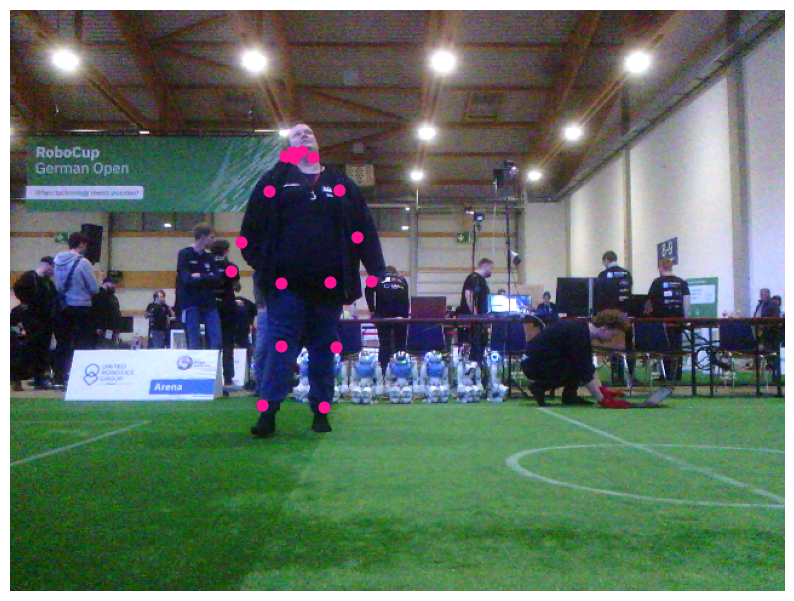

In [11]:
from naoth.log import Reader as LogReader

game_logs = ["readyWithGloves.log"]
log_image = 1
for log_num, game_log in enumerate(game_logs):
    count = 0
    with LogReader(str(game_log)) as gamelog_reader:
        for frame in gamelog_reader.read():
            count += 1
            message = frame["ImageTop"]

            # read each channel of yuv422 separately
            yuv422 = np.frombuffer(message.data, dtype=np.uint8)
            full_image_y = yuv422.reshape(480, 640, 2)
            #half_image_y = full_image_y[::2, ::2]
            #log_image = half_image_y / 255.0
            # TODO convert to opencv
            image = cv2.cvtColor(full_image_y, cv2.COLOR_YUV2RGB_YUYV ) 
            movenet_input = cv2.resize(image, (192, 192), cv2.INTER_LINEAR)
            #print(movenet_input.shape)
            movenet_input_batch = np.expand_dims(movenet_input, axis=0)
            keypoints_with_scores = movenet(movenet_input_batch)
            print(keypoints_with_scores)
            #print(keypoints_with_scores)
            width = 192 * 3.3
            height = 192 * 2.5
            keypoint_threshold = 0.11
            keypoints_all = []
            keypoint_edges_all = []
            edge_colors = []
            num_instances, _, _, _ = keypoints_with_scores.shape
            for idx in range(num_instances):
                kpts_x = keypoints_with_scores[0, idx, :, 1]
                kpts_y = keypoints_with_scores[0, idx, :, 0]
                kpts_scores = keypoints_with_scores[0, idx, :, 2]
                kpts_absolute_xy = np.stack(
                    [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
                kpts_above_thresh_absolute = kpts_absolute_xy[
                    kpts_scores > keypoint_threshold, :]
                keypoints_all.append(kpts_above_thresh_absolute)

            if keypoints_all:   
                keypoints_xy = np.concatenate(keypoints_all, axis=0)
            else:
                keypoints_xy = np.zeros((0, 17, 2))

            fig, axs = plt.subplots(1, 1, figsize=(10, 10))
            ax = axs
            
            ax.axis("off")
            scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)
            if keypoints_xy.shape[0]:
                scat.set_offsets(keypoints_xy)
            ax.imshow(image)
            #fig.savefig('foo.png')
            #plt.close(fig)
            break
            #ax.imsave(image, "test.png")

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
ax = axs
ax.imshow(movenet_input)
ax.axis("off")

In [42]:


#fig, axs = plt.subplots(1, 1, figsize=(10, 10))
#ax = axs
#ax.imshow(movenet_input)
#ax.axis("off")
#scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)
#if keypoints_xy.shape[0]:
#    scat.set_offsets(keypoints_xy)

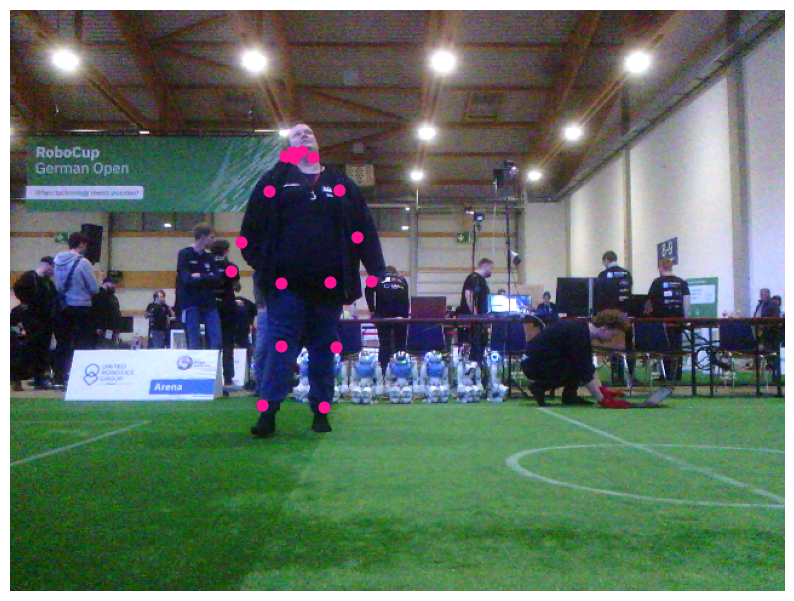

In [41]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
ax = axs
ax.imshow(image)
ax.axis("off")
scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)
if keypoints_xy.shape[0]:
    scat.set_offsets(keypoints_xy)